# Demonstration of KIP and Label Solve algorithms

# Imports

In [1]:
import dataclasses
import functools
from typing import Callable, Optional

from jax.example_libraries import optimizers
import jax
import jax.config
from jax.config import config as jax_config
jax_config.update('jax_enable_x64', True) # for numerical stability, can disable if not an issue
from jax import numpy as jnp
from jax import scipy as sp
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install -q git+https://www.github.com/google/neural-tangents

In [3]:
import neural_tangents as nt
from neural_tangents import stax

# Define Parameters

In [4]:
# architecture params
ARCHITECTURE = 'FC' #@param ['FC', 'Conv', 'Myrtle']; choice of neural network architecture yielding the corresponding NTK
DEPTH =  1#@param {'type': int}; depth of neural network
WIDTH = 1024 #@param {'type': int}; width of finite width neural network; only used if parameterization is 'standard'
PARAMETERIZATION = 'ntk' #@param ['ntk', 'standard']; whether to use standard or NTK parameterization, see https://arxiv.org/abs/2001.07301

# dataset
DATASET = 'mnist' #@param ['cifar10', 'cifar100', 'mnist', 'svhn_cropped']

# training params
LEARNING_RATE = 4e-2 #@param {'type': float};
SUPPORT_SIZE = 100  #@param {'type': int}; number of images to learn
TARGET_BATCH_SIZE = 5000  #@param {'type': int}; number of target images to use in KRR for each step
LEARN_LABELS = False #@param {'type': bool}; whether to optimize over support labels during training

# Load Data

In [5]:
def get_tfds_dataset(name):
  ds_train, ds_test = tfds.as_numpy(
      tfds.load(
          name,
          split=['train', 'test'],
          batch_size=-1,
          as_dataset_kwargs={'shuffle_files': False}))

  return ds_train['image'], ds_train['label'], ds_test['image'], ds_test['label']

def one_hot(x,
            num_classes,
            center=True,
            dtype=np.float32):
  assert len(x.shape) == 1
  one_hot_vectors = np.array(x[:, None] == np.arange(num_classes), dtype)
  if center:
    one_hot_vectors = one_hot_vectors - 1. / num_classes
  return one_hot_vectors

def get_normalization_data(arr):
  channel_means = np.mean(arr, axis=(0, 1, 2))
  channel_stds = np.std(arr, axis=(0, 1, 2))
  return channel_means, channel_stds

def normalize(array, mean, std):
  return (array - mean) / std

def unnormalize(array, mean, std):
  return (array * std) + mean


X_TRAIN_RAW, LABELS_TRAIN, X_TEST_RAW, LABELS_TEST = get_tfds_dataset(DATASET)
channel_means, channel_stds = get_normalization_data(X_TRAIN_RAW)
X_TRAIN, X_TEST = normalize(X_TRAIN_RAW, channel_means, channel_stds), normalize(X_TEST_RAW, channel_means, channel_stds) 
Y_TRAIN, Y_TEST = one_hot(LABELS_TRAIN, 10), one_hot(LABELS_TEST, 10) 

Augmentation class used to augment images

In [6]:
@dataclasses.dataclass
class Augmentor:
  """Class for creating augmentation function."""

  # function applied after augmentations (maps uint8 image to float image)
  # if standard preprocessing, this should be function which does channel-wise
  # standardization
  preprocessing_function: Callable[[np.ndarray], np.ndarray]

  # need this to unnormalize images if they are already normalized
  # before applying augmentations
  channel_means: Optional[np.ndarray] = None
  channel_stds: Optional[np.ndarray] = None

  # Specify these to augment at custom rate
  augmentation_frac: float = 1.0
  rotation_range: float = 0.0
  width_shift_range: float = 0.0
  height_shift_range: float = 0.0
  horizontal_flip: bool = False
  channel_shift_range: float = 0.0

  def __post_init__(self):
    self.aug_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=self.rotation_range,
        width_shift_range=self.width_shift_range,
        height_shift_range=self.height_shift_range,
        horizontal_flip=self.horizontal_flip,
        channel_shift_range=self.channel_shift_range,
        preprocessing_function=self.preprocessing_function,
    )

  def __call__(self,
               x: np.ndarray,
               normalized: bool = True,
               seed: Optional[int] = None):
    """Augments a numpy array of images.

    Args:
      x: image array (B,H,W,C)
      normalized: if True, then image is assumed to be standard preprocessed and
        therefore must be unnormalized before augmented
      seed: random seed for augmentations

    Returns:
      augmented images
    """

    if self.augmentation_frac == 0.0:
      return x

    permutation = np.random.permutation(x.shape[0])
    inv_permutation = get_inverse_permutation(permutation)
    num_aug_images = int(self.augmentation_frac * x.shape[0])

    x = x[permutation]
    if normalized:
      x_raw = unnormalize(x, self.channel_means, self.channel_stds)
    else:
      x_raw = x

    iterator = self.aug_generator.flow(  # pytype: disable=attribute-error
        x_raw[:num_aug_images],
        batch_size=num_aug_images,
        shuffle=False,
        seed=seed)
    x_aug = next(iterator)
    x_aug = np.concatenate([x_aug, x[num_aug_images:]])
    return x_aug[inv_permutation]

def get_inverse_permutation(perm):
  array = np.zeros_like(perm)
  array[perm] = np.arange(len(perm), dtype=int)
  return array

# Define Kernel

In [7]:
# define architectures

def FullyConnectedNetwork( 
    depth,
    width,
    W_std = np.sqrt(2), 
    b_std = 0.1,
    num_classes = 10,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax fully connected network."""
  activation_fn = stax.Relu()
  dense = functools.partial(
      stax.Dense, W_std=W_std, b_std=b_std, parameterization=parameterization)

  layers = [stax.Flatten()]
  for _ in range(depth):
    layers += [dense(width), activation_fn]
  layers += [stax.Dense(num_classes, W_std=W_std, b_std=b_std, 
                        parameterization=parameterization)]

  return stax.serial(*layers)

def FullyConvolutionalNetwork( 
    depth,
    width,
    W_std = np.sqrt(2), 
    b_std = 0.1,
    num_classes = 10,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax fully convolutional network."""
  activation_fn = stax.Relu()
  conv = functools.partial(
      stax.Conv,
      W_std=W_std,
      b_std=b_std,
      padding='SAME',
      parameterization=parameterization)

  for _ in range(depth):
    layers += [conv(width, (3,3)), activation_fn]
  layers += [stax.Flatten(), stax.Dense(num_classes, W_std=W_std, b_std=b_std,
                                        parameterization=parameterization)]

  return stax.serial(*layers)

def MyrtleNetwork(  
    depth,
    width,
    W_std = np.sqrt(2), 
    b_std = 0.1,
    num_classes = 10,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax Myrtle network."""
  layer_factor = {5: [1, 1, 1], 7: [1, 2, 2], 10: [2, 3, 3]}
  if depth not in layer_factor.keys():
    raise NotImplementedError(
        'Myrtle network withd depth %d is not implemented!' % depth)
  activation_fn = stax.Relu()
  layers = []
  conv = functools.partial(
      stax.Conv,
      W_std=W_std,
      b_std=b_std,
      padding='SAME',
      parameterization=parameterization)
  layers += [conv(width, (3, 3)), activation_fn]

  # generate blocks of convolutions followed by average pooling for each
  # layer of layer_factor except the last
  for block_depth in layer_factor[depth][:-1]:
    for _ in range(block_depth):
      layers += [conv(width, (3, 3)), activation_fn]
    layers += [stax.AvgPool((2, 2), strides=(2, 2))]

  # generate final blocks of convolution followed by global average pooling
  for _ in range(layer_factor[depth][-1]):
    layers += [conv(width, (3, 3)), activation_fn]
  layers += [stax.GlobalAvgPool()]

  layers += [
      stax.Dense(num_classes, W_std, b_std, parameterization=parameterization)
  ]

  return stax.serial(*layers)

def get_kernel_fn(architecture, depth, width, parameterization):
  if architecture == 'FC':
    return FullyConnectedNetwork(depth=depth, width=width, parameterization=parameterization)
  elif architecture == 'Conv':
    return FullyConvolutionalNetwork(depth=depth, width=width, parameterization=parameterization)
  elif architecture == 'Myrtle':
    return MyrtleNetwork(depth=depth, width=width, parameterization=parameterization)
  else:
    raise NotImplementedError(f'Unrecognized architecture {architecture}')

In [8]:
_, _, kernel_fn = get_kernel_fn(ARCHITECTURE, DEPTH, WIDTH, PARAMETERIZATION)
KERNEL_FN = jax.jit(functools.partial(kernel_fn, get='ntk'))

# Run KIP

In [9]:
def class_balanced_sample(sample_size: int, 
                          labels: np.ndarray,
                          *arrays: np.ndarray, **kwargs: int):
  """Get random sample_size unique items consistently from equal length arrays.

  The items are class_balanced with respect to labels.

  Args:
    sample_size: Number of elements to get from each array from arrays. Must be
      divisible by the number of unique classes
    labels: 1D array enumerating class label of items
    *arrays: arrays to sample from; all have same length as labels
    **kwargs: pass in a seed to set random seed

  Returns:
    A tuple of indices sampled and the corresponding sliced labels and arrays
  """
  if labels.ndim != 1:
    raise ValueError(f'Labels should be one-dimensional, got shape {labels.shape}')
  n = len(labels)
  if not all([n == len(arr) for arr in arrays[1:]]):
    raise ValueError(f'All arrays to be subsampled should have the same length. Got lengths {[len(arr) for arr in arrays]}')
  classes = np.unique(labels)
  n_classes = len(classes)
  n_per_class, remainder = divmod(sample_size, n_classes)
  if remainder != 0:
    raise ValueError(
        f'Number of classes {n_classes} in labels must divide sample size {sample_size}.'
    )
  if kwargs.get('seed') is not None:
    np.random.seed(kwargs['seed'])
  inds = np.concatenate([
      np.random.choice(np.where(labels == c)[0], n_per_class, replace=False)
      for c in classes
  ])
  return (inds, labels[inds].copy()) + tuple(
      [arr[inds].copy() for arr in arrays])

def make_loss_acc_fn(kernel_fn):

  @jax.jit
  def loss_acc_fn(x_support, y_support, x_target, y_target, reg=1e-6):
    y_support = jax.lax.cond(LEARN_LABELS, lambda y: y, jax.lax.stop_gradient, y_support)
    k_ss = kernel_fn(x_support, x_support)
    k_ts = kernel_fn(x_target, x_support)
    k_ss_reg = (k_ss + jnp.abs(reg) * jnp.trace(k_ss) * jnp.eye(k_ss.shape[0]) / k_ss.shape[0])
    pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))
    mse_loss = 0.5*jnp.mean((pred - y_target) ** 2)
    acc = jnp.mean(jnp.argmax(pred, axis=1) == jnp.argmax(y_target, axis=1))
    return mse_loss, acc

  return loss_acc_fn

def get_update_functions(init_params, kernel_fn, lr):
  opt_init, opt_update, get_params = optimizers.adam(lr) 
  opt_state = opt_init(init_params)
  loss_acc_fn = make_loss_acc_fn(kernel_fn)
  value_and_grad = jax.value_and_grad(lambda params, x_target, y_target: loss_acc_fn(params['x'],
                                                                       params['y'],
                                                                       x_target,
                                                                       y_target), has_aux=True)

  @jax.jit
  def update_fn(step, opt_state, params, x_target, y_target):
    (loss, acc), dparams = value_and_grad(params, x_target, y_target)
    return opt_update(step, dparams, opt_state), (loss, acc)

  return opt_state, get_params, update_fn

def train(num_train_steps, log_freq=20, seed=1):

  _, labels_init, x_init_raw, y_init = class_balanced_sample(SUPPORT_SIZE, LABELS_TRAIN, X_TRAIN_RAW, Y_TRAIN, seed=seed)
  x_init = normalize(x_init_raw, channel_means, channel_stds)
  params_init = {'x': x_init, 'y': y_init}
  params_init_raw = {'x': x_init_raw, 'y': labels_init}

  opt_state, get_params, update_fn = get_update_functions(params_init, KERNEL_FN, LEARNING_RATE)
  params = get_params(opt_state)
  loss_acc_fn = make_loss_acc_fn(KERNEL_FN)

  test_loss, test_acc = loss_acc_fn(params['x'], params['y'], X_TEST, Y_TEST)  # compute in batches for expensive kernels
  print('initial test loss:', test_loss)
  print('initial test acc:', test_acc)

  for i in range(1,num_train_steps+1):
    # full batch gradient descent
    _, _, x_target_batch, y_target_batch = class_balanced_sample(TARGET_BATCH_SIZE, LABELS_TRAIN, X_TRAIN, Y_TRAIN) 
    opt_state, aux = update_fn(i, opt_state, params, x_target_batch, y_target_batch)
    train_loss, train_acc = aux
    params = get_params(opt_state)
    if i % log_freq == 0:
      print(f'----step {i}:')
      print('train loss:', train_loss)
      print('train acc:', train_acc)
      test_loss, test_acc = loss_acc_fn(params['x'], params['y'], X_TEST, Y_TEST)  # compute in batches for expensive kernels
      print('test loss:', test_loss)
      print('test acc:', test_acc)

  return params, params_init, params_init_raw

## Run KIP to learn SUPPORT_SIZE=100 number of images using FC1 kernel. Algorithm converges rapidly (less than 300 training steps needed in below run for reasonable performance). Train for ~ 1000 or more steps for full convergence.

In [10]:
params_final, params_init, params_init_raw = train(300)

<ipython-input-9-3040ea114360>:47: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))


initial test loss: 0.024267245940376273
initial test acc: 0.7436


<ipython-input-9-3040ea114360>:47: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))


----step 20:
train loss: 0.015444331427902809
train acc: 0.89599997
test loss: 0.015054413700210217
test acc: 0.9037
----step 40:
train loss: 0.01372491782835145
train acc: 0.9162
test loss: 0.013192639334320855
test acc: 0.91969997
----step 60:
train loss: 0.012410749453760726
train acc: 0.9208
test loss: 0.011857062688475665
test acc: 0.92749995
----step 80:
train loss: 0.011077974376306537
train acc: 0.9378
test loss: 0.010909245871188078
test acc: 0.9357
----step 100:
train loss: 0.010309845831155273
train acc: 0.936
test loss: 0.010299281437174271
test acc: 0.93909997
----step 120:
train loss: 0.010064469607374242
train acc: 0.94119996
test loss: 0.009838605972941658
test acc: 0.9432
----step 140:
train loss: 0.009709778703797805
train acc: 0.94699997
test loss: 0.009549037313799786
test acc: 0.9447
----step 160:
train loss: 0.009469791450590547
train acc: 0.944
test loss: 0.009347282836121094
test acc: 0.94659996
----step 180:
train loss: 0.009084653381079128
train acc: 0.949
tes

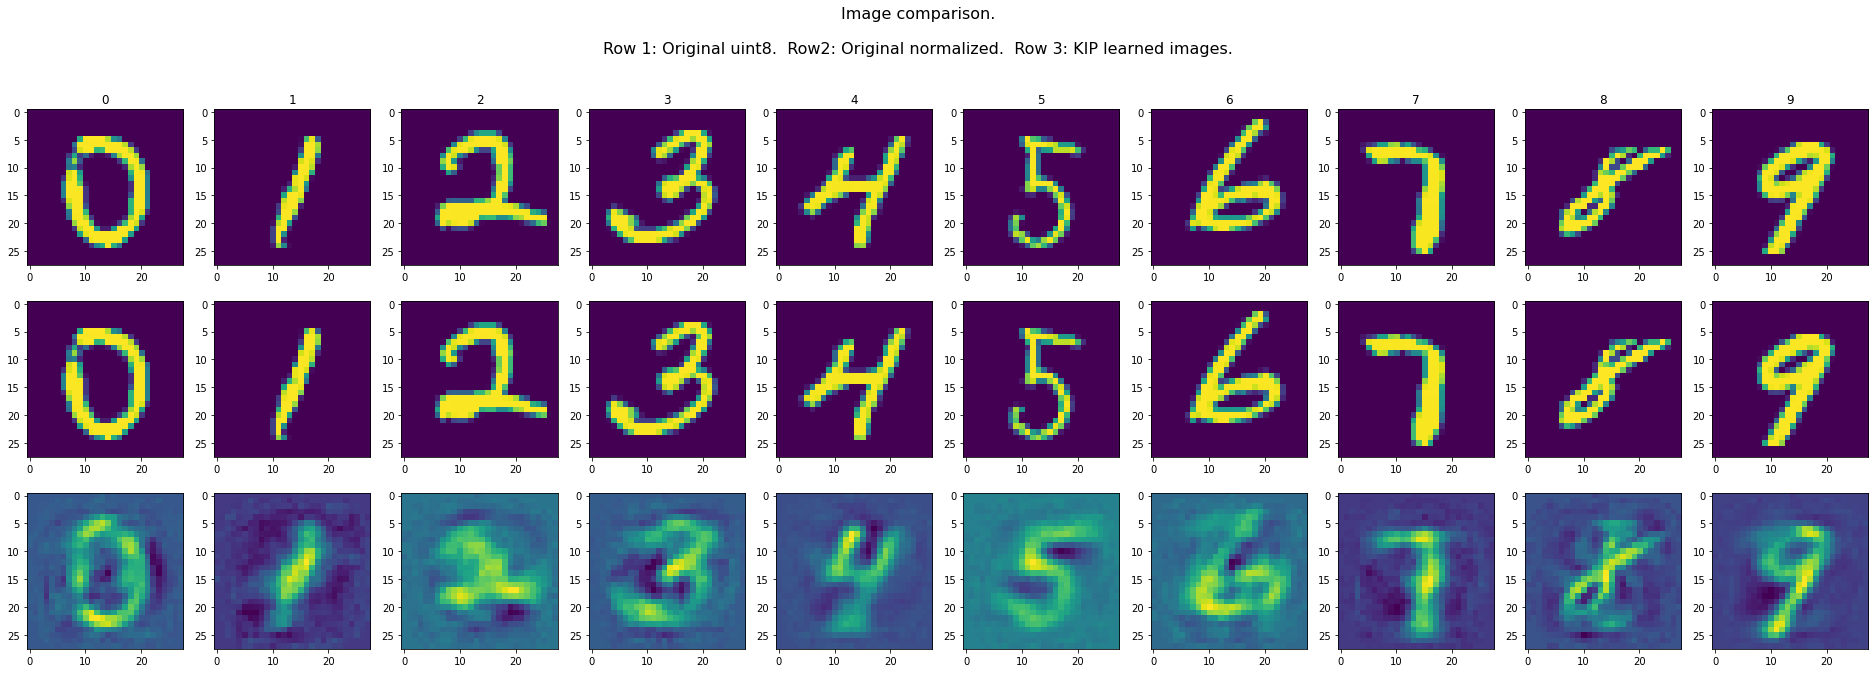

In [11]:
_, _, sample_raw, sample_init, sample_final = class_balanced_sample(10, params_init_raw['y'], params_init_raw['x'], params_init['x'], params_final['x'], seed=3)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

fig = plt.figure(figsize=(33,10))
fig.suptitle('Image comparison.\n\nRow 1: Original uint8.  Row2: Original normalized.  Row 3: KIP learned images.', fontsize=16, y=1.02)
for i, img in enumerate(sample_raw):
  ax = plt.subplot(3, 10, i+1)
  ax.set_title(class_names[i])
  plt.imshow(np.squeeze(img))

for i, img in enumerate(sample_init, 1):
  plt.subplot(3, 10, 10+i)
  plt.imshow(np.squeeze(img))

for i, img in enumerate(sample_final, 1):
  plt.subplot(3, 10, 20+i)
  plt.imshow(np.squeeze(img))

# Run Label Solve

In [12]:
def make_label_solve_fn(kernel_fn):

  @jax.jit
  def label_solve(x_support, x_target, y_target, reg=1e-6):
    """Formula for label solve valid when |x_support| <= |x_target|. A regularized version of the pseudo-inverse is used for numerical stability."""
    kss = kernel_fn(x_support, x_support)
    kst = kernel_fn(x_support, x_target)
    matrix = jnp.dot(kst, kst.T)
    matrix_reg = matrix + reg * jnp.eye(matrix.shape[0])/matrix.shape[0]
    reg_pinv = sp.linalg.solve(matrix_reg, jnp.dot(kst, y_target), sym_pos=True)
    return jnp.dot(kss + reg* jnp.eye(kss.shape[0])/kss.shape[0], reg_pinv)

  return label_solve

## Label solve using 500 MNIST images using FC1 kernel

In [13]:
_, _, x_support, y_support = class_balanced_sample(500, LABELS_TRAIN, X_TRAIN, Y_TRAIN, seed=2021)
solved_labels = make_label_solve_fn(KERNEL_FN)(x_support, X_TRAIN, Y_TRAIN)

loss_acc_fn = make_loss_acc_fn(KERNEL_FN)
loss_orig, acc_orig = loss_acc_fn(x_support, y_support, X_TEST, Y_TEST)
loss_solved, acc_solved = loss_acc_fn(x_support, solved_labels, X_TEST, Y_TEST)
print(f'Original test loss: {loss_orig}, test acc: {acc_orig}')
print(f'Label solved test loss: {loss_solved}, test acc: {acc_solved}')

<ipython-input-12-5009e6622cd7>:10: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  reg_pinv = sp.linalg.solve(matrix_reg, jnp.dot(kst, y_target), sym_pos=True)
<ipython-input-9-3040ea114360>:47: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))
<ipython-input-9-3040ea114360>:47: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))


Original test loss: 0.013824155334317478, test acc: 0.8949999809265137
Label solved test loss: 0.009222203996726751, test acc: 0.9477999806404114


In [14]:
inds = np.random.choice(50000, 500)
x_support, y_support = X_TRAIN[inds], Y_TRAIN[inds]
solved_labels = make_label_solve_fn(KERNEL_FN)(x_support, X_TRAIN, Y_TRAIN)

loss_acc_fn = make_loss_acc_fn(KERNEL_FN)
loss_orig, acc_orig = loss_acc_fn(x_support, y_support, X_TEST, Y_TEST)
loss_solved, acc_solved = loss_acc_fn(x_support, solved_labels, X_TEST, Y_TEST)
print(f'Original test loss: {loss_orig}, test acc: {acc_orig}')
print(f'Label solved test loss: {loss_solved}, test acc: {acc_solved}')

<ipython-input-12-5009e6622cd7>:10: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  reg_pinv = sp.linalg.solve(matrix_reg, jnp.dot(kst, y_target), sym_pos=True)
<ipython-input-9-3040ea114360>:47: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))
<ipython-input-9-3040ea114360>:47: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))


Original test loss: 0.014110072785503781, test acc: 0.892799973487854
Label solved test loss: 0.009259792463241216, test acc: 0.9466999769210815


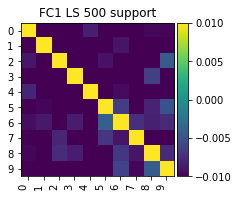

In [15]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots(figsize=(3, 3))
im = ax.imshow(np.dot(y_support.T, solved_labels)/solved_labels.shape[0], 
               vmin=-0.01, vmax=0.01)
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_xticklabels(class_names, rotation = 90, ha="right")
ax.set_yticklabels(class_names, rotation = 0, ha="right")
ax_divider = make_axes_locatable(ax)
# Add an axes to the right of the main axes.
cax = ax_divider.append_axes("right", size="7%", pad="2%")
fig.colorbar(im, cax=cax)
ax.set_title('FC1 LS 500 support')
plt.show()